In [1]:
import os
import sys
import json
import argparse

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from glob import glob
from nilearn import plotting

In [ ]:
'''
import argparse

parser = argparse.ArgumentParser(
                description='Subject-level modeling of fmriprep-preprocessed data',
                epilog='Example: python bids_modeling.py --sub=FLT02 --task=tonecat --space=T1w --fwhm=1.5 --event_type=sound --t_acq=1 --t_r=2'
        )

parser.add_argument("--sub", help="participant id", type=str)
parser.add_argument("--task", help="task id", type=str)
parser.add_argument("--space", help="space label", type=str)
parser.add_argument("--fwhm", help="spatial smoothing full-width half-max", type=str)
parser.add_argument("--event_type", help="what to model (options: `stimulus` or `feedback`)", type=float)
parser.add_argument("--t_acq", help="BOLD acquisition time (if different from repetition time [TR], as in sparse designs)", type=float)
parser.add_argument("--t_r", help="BOLD repetition time", type=float)


args = parser.parse_args()

if len(sys.argv) < 2:
    parser.print_help()
    print(' ')
    sys.exit(1)
    
subject_id = args.sub
task_id = args.task
space_label=args.space
fwhm = args.fwhm
event_type=args.event_type
t_acq = args.t_acq
t_r = args.t_r
'''

In [2]:

# ### import data with `pybids` 
# based on: https://github.com/bids-standard/pybids/blob/master/examples/pybids_tutorial.ipynb
def import_bids_data(bidsroot, subject_id, task_label):
    from bids import BIDSLayout

    layout = BIDSLayout(bidsroot)

    all_files = layout.get()
    t1w_fpath = layout.get(return_type='filename', subject=subject_id, 
                            suffix='T1w', extension='nii.gz')[0]
    bold_files = layout.get(return_type='filename', subject=subject_id, 
                            suffix='bold', task=task_label, extension='nii.gz')
    return all_files, t1w_fpath, bold_files



In [3]:

# ## nilearn modeling: first level
# based on: https://nilearn.github.io/auto_examples/04_glm_first_level/plot_bids_features.html#sphx-glr-auto-examples-04-glm-first-level-plot-bids-features-py

def prep_models_and_args(subject_id=None, task_id=None, fwhm=None, bidsroot=None, 
                         deriv_dir=None, event_type=None, t_r=None, t_acq=None, space_label='T1w'):
    from nilearn.glm.first_level import first_level_from_bids
    data_dir = bidsroot

    task_label = task_id
    fwhm_sub = fwhm

    # correct the fmriprep-given slice reference (middle slice, or 0.5)
    # to account for sparse acquisition (silent gap during auditory presentation paradigm)
    # fmriprep is explicitly based on slice timings, while nilearn is based on t_r
    # and since images are only collected during a portion of the overall t_r (which includes the silent gap),
    # we need to account for this
    slice_time_ref = 0.5 * t_acq / t_r

    print(data_dir, task_label, space_label)

    models, models_run_imgs, models_events, models_confounds = first_level_from_bids(data_dir, task_label, space_label,
                                                                                     [subject_id],
                                                                                     smoothing_fwhm=fwhm,
                                                                                     derivatives_folder=deriv_dir,
                                                                                     slice_time_ref=slice_time_ref)

    # fill n/a with 0
    [[mc.fillna(0, inplace=True) for mc in sublist] for sublist in models_confounds]

    # define which confounds to keep as nuisance regressors
    conf_keep_list = ['framewise_displacement',
                    #'a_comp_cor_00', 'a_comp_cor_01', 
                    #'a_comp_cor_02', 'a_comp_cor_03', 
                    #'a_comp_cor_04', 'a_comp_cor_05', 
                    #'a_comp_cor_06', 'a_comp_cor_07', 
                    #'a_comp_cor_08', 'a_comp_cor_09', 
                    'trans_x', 'trans_y', 'trans_z', 
                    'rot_x','rot_y', 'rot_z']

    ''' create events '''
    # stimulus events
    if event_type == 'stimulus':
        for sx, sub_events in enumerate(models_events):
            print(models[sx].subject_label)
            for mx, run_events in enumerate(sub_events):

                name_groups = run_events.groupby('trial_type')['trial_type']
                suffix = name_groups.cumcount() + 1
                repeats = name_groups.transform('size')

                run_events['trial_type'] = run_events['trial_type']
                run_events['trial_type'] = run_events['trial_type'].str.replace('-','_')

        # create stimulus list from updated events.tsv file
        stim_list = sorted([s for s in run_events['trial_type'].unique() if str(s) != 'nan'])
    
    # trial-specific events
    if event_type == 'trial':
        for sx, sub_events in enumerate(models_events):
            print(models[sx].subject_label)
            for mx, run_events in enumerate(sub_events):

                name_groups = run_events.groupby('trial_type')['trial_type']
                suffix = name_groups.cumcount() + 1
                repeats = name_groups.transform('size')

                run_events['trial_type'] = run_events['trial_type'] + \
                                                    '_trial' + suffix.map(str)
                run_events['trial_type'] = run_events['trial_type'].str.replace('-','_')

        # create stimulus list from updated events.tsv file
        stim_list = sorted([s for s in run_events['trial_type'].unique() if str(s) != 'nan'])

    # all sound events
    elif event_type == 'sound':
        for sx, sub_events in enumerate(models_events):
            print(models[sx].subject_label)
            for mx, run_events in enumerate(sub_events):
                orig_stim_list = sorted([str(s) for s in run_events['trial_type'].unique() if str(s) not in ['nan', 'None']])
                print('original stim list: ', orig_stim_list)

                run_events['trial_type'] = run_events.trial_type.str.split('_', expand=True)[0]

        # create stimulus list from updated events.tsv file
        stim_list = sorted([str(s) for s in run_events['trial_type'].unique() if str(s) not in ['nan', 'None']])
        print('stim list: ', stim_list)

    #model_and_args = zip(models, models_run_imgs, models_events, models_confounds)
    return stim_list, models, models_run_imgs, models_events, models_confounds, conf_keep_list



In [4]:

# ### Across-runs GLM
def nilearn_glm_across_runs(stim_list, task_label, models, models_run_imgs, \
                            models_events, models_confounds, conf_keep_list, space_label):
    from nilearn.reporting import make_glm_report
    for midx in range(len(models)):
        for sx, stim in enumerate(stim_list):
            contrast_label = stim
            contrast_desc  = stim


            midx = 0
            model = models[midx]
            imgs = models_run_imgs[midx]
            events = models_events[midx]
            confounds = models_confounds[midx]

            print(model.subject_label)

            # set limited confounds
            print('selecting confounds')
            confounds_ltd = [models_confounds[midx][cx][conf_keep_list] for cx in range(len(models_confounds[midx]))]
            
            try:
                # fit the GLM
                print('fitting GLM')
                model.fit(imgs, events, confounds_ltd);

                # compute the contrast of interest
                print('computing contrast of interest')
                summary_statistics = model.compute_contrast(contrast_label, output_type='all')
                zmap = summary_statistics['z_score']
                statmap = summary_statistics['effect_size']

                # save z map
                print('saving z-map')
                nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                            'level-1_fwhm-%.02f'%model.smoothing_fwhm, 
                                            'sub-%s_space-%s'%(model.subject_label, space_label),
                                            'run-all')
                if not os.path.exists(nilearn_sub_dir):
                    os.makedirs(nilearn_sub_dir)

                analysis_prefix = 'sub-%s_task-%s_fwhm-%.02f_space-%s_contrast-%s'%(model.subject_label,
                                                                                    task_label, model.smoothing_fwhm,
                                                                                    space_label, contrast_desc)
                zmap_fpath = os.path.join(nilearn_sub_dir,
                                        analysis_prefix+'_zmap.nii.gz')
                nib.save(zmap, zmap_fpath)
                print('saved z map to ', zmap_fpath)

                # also save beta maps
                statmap_fpath = os.path.join(nilearn_sub_dir,
                                            analysis_prefix+'_map-beta.nii.gz')
                nib.save(statmap, statmap_fpath)
                print('saved beta map to ', statmap_fpath)

                # save report
                print('saving report')
                report_fpath = os.path.join(nilearn_sub_dir,
                                            analysis_prefix+'_report.html')
                report = make_glm_report(model=model,
                                        contrasts=contrast_label)
                report.save_as_html(report_fpath)
                print('saved report to ', report_fpath)
            except:
                print('could not run for ', contrast_label)
    return zmap_fpath, statmap_fpath, contrast_label


In [5]:

# ### Run-by-run GLM fit
def nilearn_glm_per_run(stim_list, task_label, event_filter, models, models_run_imgs, \
                        models_events, models_confounds, conf_keep_list, space_label):
    from nilearn.reporting import make_glm_report
    for midx in range(len(models)):
        stim_contrast_list = []
        for sx, stim in enumerate(stim_list):
            contrast_label = stim
            contrast_desc  = stim
            
            if event_filter in stim:
                print('running GLM with stimulus ', stim)

                midx = 0
                model = models[midx]
                imgs = models_run_imgs[midx]
                events = models_events[midx]
                confounds = models_confounds[midx]

                print(model.subject_label)

                # set limited confounds
                print('selecting confounds')
                confounds_ltd = [models_confounds[midx][cx][conf_keep_list] for cx in range(len(models_confounds[midx]))]

                for rx in range(len(imgs)):
                    img = imgs[rx]
                    event = events[rx]
                    confound = confounds_ltd[rx]

                    try:
                        # fit the GLM
                        print('fitting GLM on ', img)
                        model.fit(img, event, confound);

                        # compute the contrast of interest
                        print('computing contrast of interest', ' with contrast label = ', contrast_label)
                        statmap = model.compute_contrast(contrast_label, output_type='effect_size')

                        # save stat map
                        print('saving beta map')
                        nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                                    'level-1_fwhm-%.02f'%model.smoothing_fwhm, 
                                                    'sub-%s_space-%s'%(model.subject_label, space_label))
                        if 'trial' in stim:
                            nilearn_sub_run_dir = os.path.join(nilearn_sub_dir, 'trial_models', 'run%02d'%rx)
                        else:
                            nilearn_sub_run_dir = os.path.join(nilearn_sub_dir, 'stimulus_per_run', 'run%02d'%rx)

                        if not os.path.exists(nilearn_sub_run_dir):
                            os.makedirs(nilearn_sub_run_dir)

                        analysis_prefix = ('sub-%s_task-%s_fwhm-%.02f_'
                                           'space-%s_contrast-%s_run%02d'%(model.subject_label,
                                                                           task_label, model.smoothing_fwhm,
                                                                           space_label, contrast_desc,
                                                                           rx))
                        statmap_fpath = os.path.join(nilearn_sub_run_dir,
                                                analysis_prefix+'_map-beta.nii.gz')
                        nib.save(statmap, statmap_fpath)
                        print('saved beta map to ', statmap_fpath)

                        stim_contrast_list.append(contrast_label)

                    except:
                        print('could not run for ', img, ' with ', contrast_label)

In [6]:

def plot_stat_maps(zmap, nilearn_dir, p_val=0.005):
    from scipy.stats import norm
    thresh_unc = norm.isf(p_val)

    # plot
    fig, axes = plt.subplots(3, 1, figsize=(20, 15))
    plotting.plot_stat_map(zmap, bg_img=t1w_fpath, colorbar=True, threshold=thresh_unc,
                        title='sub-%s %s (unc p<%.03f; fwhm=%.02f)'%(model.subject_label, 
                                                                    contrast_label ,p_val,fwhm_sub),
                        axes=axes[0],
                        display_mode='x', cut_coords=6)
    plotting.plot_stat_map(zmap, bg_img=t1w_fpath, colorbar=True, threshold=thresh_unc,
                        axes=axes[1],
                        display_mode='y', cut_coords=6)
    plotting.plot_stat_map(zmap, bg_img=t1w_fpath, colorbar=True, threshold=thresh_unc,
                        axes=axes[2],
                        display_mode='z', cut_coords=6)
    plotting.show()

    # save plot
    plot_fpath = os.path.join(nilearn_dir, 
                            'sub-%s_task-%s_fwhm-%.02f_pval-%.03f_space-%s_contrast-%s.png'%(model.subject_label,
                                                                        task_label,fwhm_sub, p_val,
                                                                        space_label, contrast_desc))
    fig.savefig(plot_fpath)

    return plot_fpath

# ## plot tsnr
def plot_tsnr(bold_files):
    from nilearn import image

    thresh = 0
    fwhm = 5

    for fx,filepath in enumerate(bold_files):
        tsnr_func = image.math_img('img.mean(axis=3) / img.std(axis=3)', img=filepath)
        tsnr_func_smooth = image.smooth_img(tsnr_func, fwhm=5)

        display = plotting.plot_stat_map(tsnr_func_smooth, 
                                        bg_img=t1w_fpath, 
                                        #title='fMRI single run tSNR map',
                                        #cut_coords=[8,50,-20],
                                        #threshold=thresh, 
                                        #cmap='jet'
                                        );
        display.show()

## Run pipelines

In [7]:
task_label = 'tonecat'
t_acq = 2
t_r = 3

project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
#bidsroot = os.path.join(project_dir,'data_bids')
bidsroot = os.path.join(project_dir,'data_bids_noIntendedFor')
deriv_dir = os.path.join(project_dir, 'derivatives', 'fmriprep_noSDC')

nilearn_dir = os.path.join(deriv_dir, 'nilearn')
if not os.path.exists(nilearn_dir):
        os.makedirs(nilearn_dir)

### Univariate analysis

Takes approximately 30 minutes per subject

In [7]:
space_label = 'MNI152NLin2009cAsym'
subject_list = ['FLT02', 'FLT03', 'FLT05', ] # 
# 'FLT01', 'FLT04', 'FLT06', 'FLT07', 'FLT08', 'FLT09', 'FLT10', 'FLT11', 'FLT12', 'FLT13',

In [8]:
for sx, subject_id in enumerate(subject_list):
    print('Running subject ', subject_id)
    # Univariate analysis: MNI space, 3 mm, across-run GLM
    stim_list, models, models_run_imgs, \
        models_events, models_confounds, conf_keep_list = prep_models_and_args(subject_id, task_label, 
                                                                                 3.0, bidsroot, 
                                                                                 deriv_dir, 'sound',
                                                                                 t_r, t_acq, 
                                                                                 space_label)
    # Across-run GLM
    zmap_fpath, statmap_fpath, contrast_label = nilearn_glm_across_runs(stim_list, task_label, 
                                                                        models, models_run_imgs, 
                                                                        models_events, models_confounds, 
                                                                        conf_keep_list, space_label)

Running subject  FLT02
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor tonecat MNI152NLin2009cAsym


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:948: UserWarning: SliceTimingRef not found in file /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_hemi-L_space-fsnative_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


FLT02
original stim list:  ['fb_correct', 'fb_wrong', 'resp_1', 'resp_2', 'resp_3', 'resp_7', 'resp_8', 'resp_None', 'sound_di1-aN', 'sound_di1-bN', 'sound_di1-hN', 'sound_di1-iN', 'sound_di2-aN', 'sound_di2-bN', 'sound_di2-hN', 'sound_di2-iN', 'sound_di3-aN', 'sound_di3-bN', 'sound_di3-hN', 'sound_di3-iN', 'sound_di4-aN', 'sound_di4-bN', 'sound_di4-hN', 'sound_di4-iN']
original stim list:  ['fb_correct', 'fb_wrong', 'resp_1', 'resp_2', 'resp_6', 'resp_7', 'resp_None', 'sound_di1-aN', 'sound_di1-bN', 'sound_di1-hN', 'sound_di1-iN', 'sound_di2-aN', 'sound_di2-bN', 'sound_di2-hN', 'sound_di2-iN', 'sound_di3-aN', 'sound_di3-bN', 'sound_di3-hN', 'sound_di3-iN', 'sound_di4-aN', 'sound_di4-bN', 'sound_di4-hN', 'sound_di4-iN']
original stim list:  ['fb_correct', 'fb_wrong', 'resp_1', 'resp_2', 'resp_6', 'resp_7', 'resp_None', 'sound_di1-aN', 'sound_di1-bN', 'sound_di1-hN', 'sound_di1-iN', 'sound_di2-aN', 'sound_di2-bN', 'sound_di2-hN', 'sound_di2-iN', 'sound_di3-aN', 'sound_di3-bN', 'sound_di

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/run-all/sub-FLT02_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-fb_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/run-all/sub-FLT02_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-fb_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/run-all/sub-FLT02_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-fb_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/run-all/sub-FLT02_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-resp_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/run-all/sub-FLT02_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-resp_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/run-all/sub-FLT02_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-resp_report.html
FLT02
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/run-all/sub-FLT02_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/run-all/sub-FLT02_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT02_space-MNI152NLin2009cAsym/run-all/sub-FLT02_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_report.html
Running subject  FLT03
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor tonecat MNI152NLin2009cAsym


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:948: UserWarning: SliceTimingRef not found in file /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_hemi-L_space-fsnative_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


FLT03
original stim list:  ['fb_correct', 'fb_wrong', 'resp_1', 'resp_2', 'resp_6', 'resp_7', 'sound_di1-aN', 'sound_di1-bN', 'sound_di1-hN', 'sound_di1-iN', 'sound_di2-aN', 'sound_di2-bN', 'sound_di2-hN', 'sound_di2-iN', 'sound_di3-aN', 'sound_di3-bN', 'sound_di3-hN', 'sound_di3-iN', 'sound_di4-aN', 'sound_di4-bN', 'sound_di4-hN', 'sound_di4-iN']
original stim list:  ['fb_correct', 'fb_wrong', 'resp_1', 'resp_2', 'resp_6', 'resp_7', 'resp_None', 'sound_di1-aN', 'sound_di1-bN', 'sound_di1-hN', 'sound_di1-iN', 'sound_di2-aN', 'sound_di2-bN', 'sound_di2-hN', 'sound_di2-iN', 'sound_di3-aN', 'sound_di3-bN', 'sound_di3-hN', 'sound_di3-iN', 'sound_di4-aN', 'sound_di4-bN', 'sound_di4-hN', 'sound_di4-iN']
original stim list:  ['fb_correct', 'fb_wrong', 'resp_1', 'resp_2', 'resp_6', 'resp_7', 'sound_di1-aN', 'sound_di1-bN', 'sound_di1-hN', 'sound_di1-iN', 'sound_di2-aN', 'sound_di2-bN', 'sound_di2-hN', 'sound_di2-iN', 'sound_di3-aN', 'sound_di3-bN', 'sound_di3-hN', 'sound_di3-iN', 'sound_di4-aN

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/run-all/sub-FLT03_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-fb_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/run-all/sub-FLT03_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-fb_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/run-all/sub-FLT03_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-fb_report.html
FLT03
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/run-all/sub-FLT03_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-resp_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/run-all/sub-FLT03_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-resp_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/run-all/sub-FLT03_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-resp_report.html
FLT03
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/run-all/sub-FLT03_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/run-all/sub-FLT03_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT03_space-MNI152NLin2009cAsym/run-all/sub-FLT03_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_report.html
Running subject  FLT05
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor tonecat MNI152NLin2009cAsym


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:948: UserWarning: SliceTimingRef not found in file /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_hemi-L_space-fsnative_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


FLT05
original stim list:  ['fb_correct', 'fb_wrong', 'resp_1', 'resp_2', 'resp_6', 'resp_7', 'sound_di1-aN', 'sound_di1-bN', 'sound_di1-hN', 'sound_di1-iN', 'sound_di2-aN', 'sound_di2-bN', 'sound_di2-hN', 'sound_di2-iN', 'sound_di3-aN', 'sound_di3-bN', 'sound_di3-hN', 'sound_di3-iN', 'sound_di4-aN', 'sound_di4-bN', 'sound_di4-hN', 'sound_di4-iN']
original stim list:  ['fb_correct', 'fb_wrong', 'resp_1', 'resp_2', 'resp_6', 'resp_7', 'resp_None', 'sound_di1-aN', 'sound_di1-bN', 'sound_di1-hN', 'sound_di1-iN', 'sound_di2-aN', 'sound_di2-bN', 'sound_di2-hN', 'sound_di2-iN', 'sound_di3-aN', 'sound_di3-bN', 'sound_di3-hN', 'sound_di3-iN', 'sound_di4-aN', 'sound_di4-bN', 'sound_di4-hN', 'sound_di4-iN']
original stim list:  ['fb_correct', 'fb_wrong', 'resp_1', 'resp_2', 'resp_6', 'resp_7', 'sound_di1-aN', 'sound_di1-bN', 'sound_di1-hN', 'sound_di1-iN', 'sound_di2-aN', 'sound_di2-bN', 'sound_di2-hN', 'sound_di2-iN', 'sound_di3-aN', 'sound_di3-bN', 'sound_di3-hN', 'sound_di3-iN', 'sound_di4-aN

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT05_space-MNI152NLin2009cAsym/run-all/sub-FLT05_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-fb_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT05_space-MNI152NLin2009cAsym/run-all/sub-FLT05_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-fb_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT05_space-MNI152NLin2009cAsym/run-all/sub-FLT05_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-fb_report.html
FLT05
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT05_space-MNI152NLin2009cAsym/run-all/sub-FLT05_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-resp_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT05_space-MNI152NLin2009cAsym/run-all/sub-FLT05_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-resp_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT05_space-MNI152NLin2009cAsym/run-all/sub-FLT05_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-resp_report.html
FLT05
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT05_space-MNI152NLin2009cAsym/run-all/sub-FLT05_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT05_space-MNI152NLin2009cAsym/run-all/sub-FLT05_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT05_space-MNI152NLin2009cAsym/run-all/sub-FLT05_task-tonecat_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_report.html


### Multivariate analysis

Three options for multivariate analysis:
1. across-run stimulus modeling (n_output = n_stimuli)
2. within-run stimulus modeling (n_output = n_stimuli x n_runs)
3. within-run trial modeling (n_output = n_trials x n_runs)

In [8]:
space_label = 'MNI152NLin2009cAsym'
subject_list = ['FLT01', 'FLT02', 'FLT03', 'FLT04', 'FLT05', 'FLT06', 'FLT07', 'FLT08', 'FLT09', 'FLT10', 'FLT11', 'FLT12', 'FLT13',]
# 

In [9]:
print(subject_list)
print('analysis space: ', space_label)
print('task: ', task_label)
print('bids root directory: ', bidsroot)
print('derivatives directory: ', deriv_dir)

['FLT01', 'FLT02', 'FLT03', 'FLT04', 'FLT05', 'FLT06', 'FLT07', 'FLT08', 'FLT09', 'FLT10', 'FLT11', 'FLT12', 'FLT13']
analysis space:  MNI152NLin2009cAsym
task:  tonecat
bids root directory:  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor
derivatives directory:  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC


#### Stimulus modeling (across-run estimates)

In [17]:
# Multivariate analysis: T1w space, 1.5 mm, across-run GLM
event_type = 'stimulus'
event_filter = 'sound' 
for subject_id in subject_list:
    print('running with subject ', subject_id)

    stim_list, models, models_run_imgs, \
        models_events, models_confounds, conf_keep_list = prep_models_and_args(subject_id, task_label, 1.5, bidsroot, 
                                                                               deriv_dir, event_type, t_r, t_acq, 
                                                                               space_label=space_label)
    print('stim list: ', stim_list)
    statmap_fpath, contrast_label = nilearn_glm_per_run(stim_list, task_label, event_filter, models, models_run_imgs, 
                                                     models_events, models_confounds, conf_keep_list, space_label)
    #stat_maps, conditions = generate_conditions(subject_id, fwhm, space_label, deriv_dir)

running with subject  FLT08
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor tonecat T1w
FLT08


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:948: UserWarning: SliceTimingRef not found in file /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_hemi-L_space-fsnative_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `

stim list:  ['fb_correct', 'fb_wrong', 'resp_1', 'resp_2', 'resp_6', 'resp_7', 'sound_di1_aN', 'sound_di1_bN', 'sound_di1_hN', 'sound_di1_iN', 'sound_di2_aN', 'sound_di2_bN', 'sound_di2_hN', 'sound_di2_iN', 'sound_di3_aN', 'sound_di3_bN', 'sound_di3_hN', 'sound_di3_iN', 'sound_di4_aN', 'sound_di4_bN', 'sound_di4_hN', 'sound_di4_iN']
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-fb_correct_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-fb_correct_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-fb_correct_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest
could not run for  fb_wrong
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will b

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_1_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_1_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_1_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_2_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_2_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_2_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_6_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_6_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_6_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_7_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_7_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-resp_7_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_report.html
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events 

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_zmap.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 6 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT08_space-T1w/run-all/sub-FLT08_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_report.html


ValueError: too many values to unpack (expected 2)

#### Stimulus modeling: within-run GLM

In [10]:
# Multivariate analysis: T1w space, 1.5 mm, within-run GLM
event_type = 'stimulus'
event_filter = 'sound'
for subject_id in subject_list:
    print('running with subject ', subject_id)
        
    stim_list, models, models_run_imgs, \
        models_events, models_confounds, conf_keep_list = prep_models_and_args(subject_id, task_label, 1.5, bidsroot, 
                                                                               deriv_dir, event_type, t_r, t_acq, 
                                                                               space_label=space_label)
    print('stim list: ', stim_list)
    statmap_fpath, contrast_label = nilearn_glm_per_run(stim_list, task_label, event_filter, models, models_run_imgs, 
                                                     models_events, models_confounds, conf_keep_list, space_label)
    #stat_maps, conditions = generate_conditions(subject_id, fwhm, space_label, deriv_dir)

running with subject  FLT01
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor tonecat MNI152NLin2009cAsym


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:948: UserWarning: SliceTimingRef not found in file /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_hemi-L_space-fsnative_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


FLT01
stim list:  ['fb_correct', 'resp_1', 'resp_2', 'resp_6', 'resp_7', 'sound_di1_aN', 'sound_di1_bN', 'sound_di1_hN', 'sound_di1_iN', 'sound_di2_aN', 'sound_di2_bN', 'sound_di2_hN', 'sound_di2_iN', 'sound_di3_aN', 'sound_di3_bN', 'sound_di3_hN', 'sound_di3_iN', 'sound_di4_aN', 'sound_di4_bN', 'sound_di4_hN', 'sound_di4_iN']
running GLM with stimulus  sound_di1_aN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_aN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_aN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_aN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_aN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di1_bN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_bN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_bN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_bN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_bN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di1_hN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_hN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_hN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_hN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_hN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di1_iN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_iN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_iN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di1_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di1_iN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

could not run for  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz  with  sound_di1_iN
running GLM with stimulus  sound_di2_aN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_aN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_aN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_aN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_aN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di2_bN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_bN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_bN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_bN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_bN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di2_hN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_hN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_hN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_hN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_hN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di2_iN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_iN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_iN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_iN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di2_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di2_iN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di3_aN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_aN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_aN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_aN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_aN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di3_bN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_bN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_bN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_bN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_bN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di3_hN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_hN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_hN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_hN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_hN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di3_iN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_iN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_iN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_iN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di3_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di3_iN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di4_aN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_aN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_aN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_aN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_aN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_aN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di4_bN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_bN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_bN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_bN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_bN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_bN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di4_hN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_hN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_hN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_hN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_hN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_hN_run03_map-beta.nii.gz
running GLM with stimulus  sound_di4_iN
FLT01
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run00/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_iN_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run01/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_iN_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run02/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_iN_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-04_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events 

computing contrast of interest  with contrast label =  sound_di4_iN
saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT01_space-MNI152NLin2009cAsym/stimulus_per_run/run03/sub-FLT01_task-tonecat_fwhm-1.50_space-MNI152NLin2009cAsym_contrast-sound_di4_iN_run03_map-beta.nii.gz


TypeError: cannot unpack non-iterable NoneType object

#### Single trial modeling (within-run GLM)

Takes approximately 4–6 hours per subject

In [12]:
# Multivariate analysis: T1w space, 1.5 mm, within-run GLM
event_type = 'trial'
event_filter = 'sound'
for subject_id in subject_list:
    print('running with subject ', subject_id)
        
    stim_list, models, models_run_imgs, \
        models_events, models_confounds, conf_keep_list = prep_models_and_args(subject_id, task_label, 1.5, bidsroot, 
                                                                               deriv_dir, event_type, t_r, t_acq, 
                                                                               space_label=space_label)
    print('stim list: ', stim_list)
    statmap_fpath, contrast_label = nilearn_glm_per_run(stim_list, task_label, event_filter, models, models_run_imgs, 
                                                     models_events, models_confounds, conf_keep_list, space_label)
    #stat_maps, conditions = generate_conditions(subject_id, fwhm, space_label, deriv_dir)

running with subject  FLT04
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor tonecat T1w


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:948: UserWarning: SliceTimingRef not found in file /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT01/func/sub-FLT01_task-tonecat_run-01_hemi-L_space-fsnative_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  warn('SliceTimingRef not found in file %s. It will be assumed'


FLT04
stim list:  ['fb_correct_trial1', 'fb_correct_trial10', 'fb_correct_trial11', 'fb_correct_trial12', 'fb_correct_trial13', 'fb_correct_trial14', 'fb_correct_trial15', 'fb_correct_trial16', 'fb_correct_trial17', 'fb_correct_trial18', 'fb_correct_trial19', 'fb_correct_trial2', 'fb_correct_trial20', 'fb_correct_trial21', 'fb_correct_trial22', 'fb_correct_trial23', 'fb_correct_trial24', 'fb_correct_trial25', 'fb_correct_trial26', 'fb_correct_trial27', 'fb_correct_trial28', 'fb_correct_trial29', 'fb_correct_trial3', 'fb_correct_trial30', 'fb_correct_trial31', 'fb_correct_trial32', 'fb_correct_trial33', 'fb_correct_trial34', 'fb_correct_trial35', 'fb_correct_trial4', 'fb_correct_trial5', 'fb_correct_trial6', 'fb_correct_trial7', 'fb_correct_trial8', 'fb_correct_trial9', 'fb_wrong_trial1', 'fb_wrong_trial10', 'fb_wrong_trial11', 'fb_wrong_trial12', 'fb_wrong_trial13', 'fb_wrong_trial2', 'fb_wrong_trial3', 'fb_wrong_trial4', 'fb_wrong_trial5', 'fb_wrong_trial6', 'fb_wrong_trial7', 'fb_wro

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di1_aN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di1_aN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_aN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di1_bN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di1_bN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di1_bN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_bN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di1_hN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di1_hN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di1_hN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_hN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di1_iN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di1_iN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di1_iN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di1_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di1_iN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_aN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_aN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_aN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_aN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_bN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_bN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_bN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_bN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_hN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_hN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_hN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_hN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_iN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_iN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di2_iN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di2_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di2_iN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_aN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_aN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_aN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_aN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_bN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_bN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_bN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_bN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_hN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_hN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_hN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_hN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_iN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_iN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di3_iN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di3_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di3_iN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_aN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_aN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_aN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_aN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_aN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_bN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_bN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_bN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_bN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_bN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_hN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_hN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_hN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_hN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_hN_trial3_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_iN_trial1
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial1_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial1_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial1_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial1_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial1_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial1


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial1_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_iN_trial2
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial2_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial2_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial2_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial2_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial2_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial2


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial2_run05_map-beta.nii.gz
running GLM with stimulus  sound_di4_iN_trial3
FLT04
selecting confounds
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-01_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run00/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial3_run00_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-02_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run01/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial3_run01_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-03_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run02/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial3_run02_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-04_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run03/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial3_run03_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-05_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run04/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial3_run04_map-beta.nii.gz
fitting GLM on  /bgfs/bchandrasekaran/krs228/data/FLT/derivatives/fmriprep_noSDC/sub-FLT04/func/sub-FLT04_task-tonecat_run-06_space-T1w_desc-preproc_bold.nii.gz


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `correct_key` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events 

computing contrast of interest  with contrast label =  sound_di4_iN_trial3


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/model.py:206: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


saving beta map
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-T1w/trial_models/run05/sub-FLT04_task-tonecat_fwhm-1.50_space-T1w_contrast-sound_di4_iN_trial3_run05_map-beta.nii.gz


TypeError: cannot unpack non-iterable NoneType object

## Second-level analyses

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

In [8]:
import pandas as pd

In [54]:
sub_list_mand = ['FLT01', 'FLT03', 'FLT05', 'FLT07', 'FLT08', 'FLT10', ]

sub_list_nman = ['FLT02', 'FLT04', 'FLT06', 'FLT09', 'FLT11', 'FLT12', 'FLT13', ]

sub_list = sub_list_mand + sub_list_nman

In [55]:
n_subjects = len(sub_list)
design_matrix = pd.DataFrame([1] * n_subjects, columns=['intercept'])

In [56]:
design_mat_mand = pd.DataFrame([1] * len(sub_list_mand), columns=['intercept'])
design_mat_nman = pd.DataFrame([1] * len(sub_list_nman), columns=['intercept'])

In [57]:
contrast_label = 'sound'
fwhm = 4.5
space_label = 'MNI152NLin2009cAsym'
l1_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 'level-1_fwhm-%.02f'%fwhm)
l1_fnames = sorted(glob(l1_dir+'/sub-*_space-%s/run-all/*%s_map-beta.nii.gz'%(space_label, contrast_label)))


In [58]:
l1_fnames_mand = [sorted(glob(l1_dir+'/sub-%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_mand]

l1_fnames_nman = [sorted(glob(l1_dir+'/sub-%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_nman]

Mandarin-speaking group:

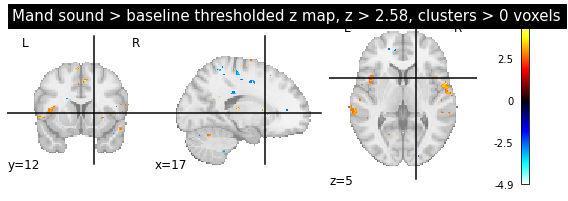

In [59]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(l1_fnames_mand, design_matrix=design_mat_mand)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn.image import threshold_img
threshold = 2.58
cthresh=0
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

Non-Mandarin speaking group:

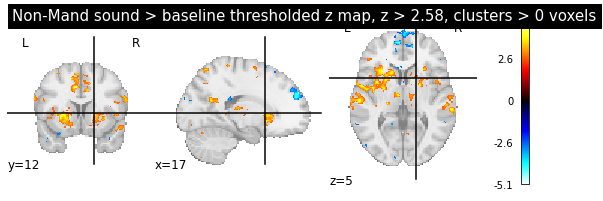

In [60]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(l1_fnames_nman, design_matrix=design_mat_nman)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn.image import threshold_img
threshold = 2.58
cthresh=0
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Non-Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

All participants

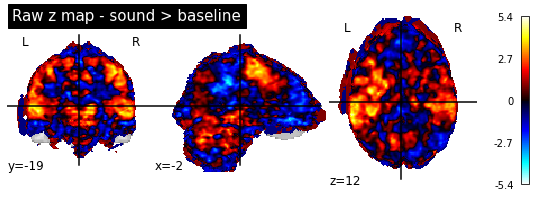

In [61]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(l1_fnames, design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn import plotting
display = plotting.plot_stat_map(z_map, title='Raw z map - %s > baseline'%contrast_label)

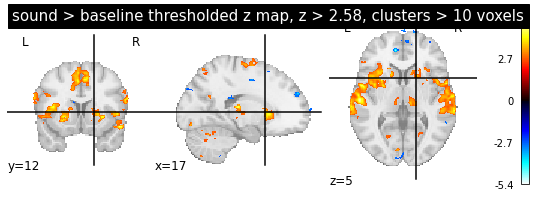

In [64]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='%s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

2.575829303548901


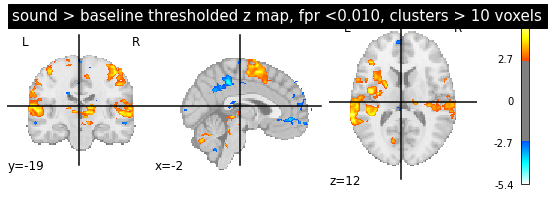

In [34]:
from nilearn.glm import threshold_stats_img
fpr_alpha = .01
cthresh = 10
thresholded_map1, \
    threshold1 = threshold_stats_img(
                                    z_map,
                                    alpha=fpr_alpha,
                                    height_control='fpr',
                                    cluster_threshold=cthresh,
                                    two_sided=True,
                                    )
plotting.plot_stat_map(
    thresholded_map1, cut_coords=display.cut_coords, threshold=threshold1,
    title='%s > baseline thresholded z map, fpr <%.03f, clusters > %d voxels'%(contrast_label, fpr_alpha, cthresh))
print(threshold1)

The FDR=.05 threshold is 3.46


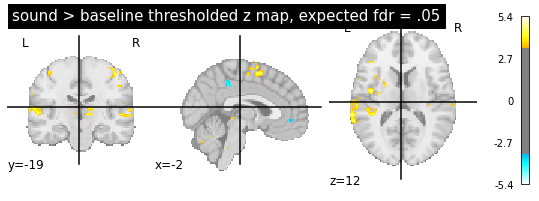

In [35]:
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

plotting.plot_stat_map(thresholded_map2, cut_coords=display.cut_coords,
                       title='%s > baseline thresholded z map, expected fdr = .05'%contrast_label,
                       threshold=threshold2)

#### Surface plots

In [39]:
from nilearn import datasets, surface

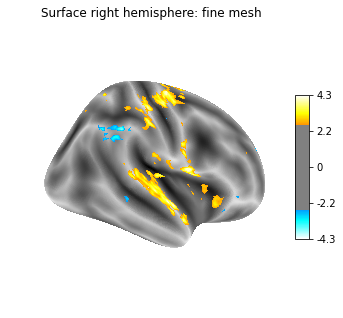

In [58]:
big_fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
big_texture = surface.vol_to_surf(z_map, big_fsaverage.pial_right)

plotting.plot_surf_stat_map(big_fsaverage.infl_right,
                            big_texture, hemi='right', colorbar=True,
                            title='Surface right hemisphere: fine mesh',
                            threshold=2.58, bg_map=big_fsaverage.sulc_right)
plotting.show()

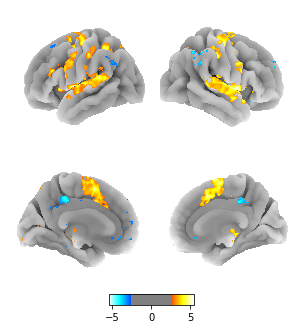

In [54]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=2.58,
                          colorbar=True)
plotting.show()